# ME308 PROJECT: AIRPLANE SCHEDULING AND COST MINIMIZATION

Given a set of routes pq on which there exists an average daily traffic Ppq which must be carried by limited numbers of different types of aircraft, find the least cost assignment of aircraft to routes such that a minimum frequency of daily service on each route is satisfied, and such that aircraft movements balance at every station while not exceeding a daily allowable maximum imposed
by airport congestion.

### Declaring all variables

In [67]:
import numpy

#Adjustable parameters
cities = 10  # no of cities being catered

# The load factor is a metric used in the airline industry that measures the percentage of available seating capacity that has been filled with passengers
LF_pq = numpy.zeros((cities, cities))
# estimated average for daily traffic from p to q
P_pq = numpy.zeros((cities, cities))
# an appropriate direct operating cost for an aircraft a on route pq
DC_pq = numpy.zeros((cities, cities))
# Stores distance between 2 airports p and q
d_pq = numpy.zeros((cities, cities))
# stores seating capacity for a given aircraft
S = 180
# estimated average for daily traffic from p to q
P_pq = numpy.zeros((cities, cities))
# block hours for aircraft a to fly route pq
# Block time includes the time to taxi-out to the runway, the actual flight duration and the time to taxi to the arrival gate, but the published schedule for the flight doesn't break these elements apart.
Tb_pq = numpy.zeros((cities, cities))
# assumed average daily utilization for fleet a [in hours] - depends on stage length as well (the amount of time plane has flown)
U = 8
# number of aircrafts
A = 50
# a specified minimum level of service should be maintained on each route
Nmin_pq = numpy.zeros((cities, cities))
# maximum number of daily departures allowed at station p
N_maxp = numpy.zeros(cities)

### Initialization of variables

Some information before code
We take three cities for testing - Mumbai, Delhi, Lucknow <br>
Distance(Mumbai->Delhi) = 1137Km <br>
Distance(Delhi->Lucknow) = 553Km <br>
Distance(Mumbai->Lucknow) = 1378km <br>
<br>
Seating capacity of plane is equal to 180 <br><br>
Since Delhi and Lucknow are close to each other people also prefer superfast trains as compared to flight since it takes same time. So load factor for Delhi to Lucknow might be low.<br>
But in our case we assume constant load factor = 1<br>
Average daily traffic from one city to other is taken as 1000 for Mumbai to Delhi, 400 for Delhi to Lucknow and 700 for Mumbai to Lucknow<br><br>
One major assumption is aircrafts fly at same velocity throughout the journey and velocity of aircraft is ~900km/hr <br>
Fuel cost = INR 40 per litre (assuming full seats) # is not valid when LF<1 though <br>
Fuel consumption = 4.18 L/km (Data for A320) <br>
DC = fuel consumption * distance * fuel cost <br>
<br>
Block time = distance/velocity + 1hr<br><br>
Assumed average utilisation is 8hrs
<br><br>
Minimum level of service = 1
<br>
Maximum level of service = 900 for Mumbai, 800 for Delhi and 100 for Lucknow
<br>
No of aircrafts = 1000



In [68]:
# Function to calculate distance given latitudes and longitudes
import numpy as np
def gcd(coord1, coord2):
    c1 = np.deg2rad(coord1) # phi lambda
    c2 = np.deg2rad(coord2)
    
    p1 = c1[0]
    p2 = c2[0]
    dl = c1[1] - c2[1]
    
    a1 = np.cos(p2) * np.sin(dl)
    a2 = np.cos(p1) * np.sin(p2) - np.sin(p1) * np.cos(p2) * np.cos(dl)
    a3 = np.sin(p1) * np.sin(p2) + np.cos(p1) * np.cos(p2) * np.cos(dl)
    dsigma = np.arctan2(np.sqrt(a1**2 + a2**2), a3)
    
    return 6371 * dsigma

In [193]:
stations = ['Mumbai', 'Delhi', 'Lucknow', 'Hyderabad', 'Ahmedabad', 'Banglore', 'Pune', 'Kolkata', 'Chennai', 'Jaipur']
coords = [(19.076090, 72.877426), (28.679079, 77.069710), (26.850000, 80.949997),
         (17.3667, 78.4667), (23.0300, 72.5800), (12.9699, 77.5980),
         (18.5196, 73.8553), (22.5411, 88.3378), (13.0825, 80.2750),
         (26.9167, 75.8667)]
# (22.5411, 88.3378)
nstations = len(stations)
distance = numpy.zeros((nstations, nstations))
for origin in stations:
    s = stations.index(origin)
    for destination in stations:
        e = stations.index(destination)
        distance[s, e] = gcd(coords[s], coords[e])
print(distance)
print(distance.shape)

[[   0.         1149.44132582 1195.2125347   620.13039223  440.73615995
   845.7132169   120.10180256 1651.58084796 1033.49264812  923.84597547]
 [1149.44132582    0.          432.54634875 1265.93694988  772.08077866
  1747.63593506 1176.01603947 1318.9274931  1765.66164478  228.91810895]
 [1195.2125347   432.54634875    0.         1084.98012845  944.43296995
  1582.41699302 1177.4090507   886.59062151 1532.48976376  504.17178599]
 [ 620.13039223 1265.93694988 1084.98012845    0.          879.47350732
   497.70633853  504.36559185 1180.75522585  514.35399983 1095.04120423]
 [ 440.73615995  772.08077866  944.43296995  879.47350732    0.
  1237.72947989  518.75054841 1615.58712906 1372.2189404   544.48343633]
 [ 845.7132169  1747.63593506 1582.41699302  497.70633853 1237.72947989
     0.          735.59155512 1556.24146884  290.27769171 1561.26388147]
 [ 120.10180256 1176.01603947 1177.4090507   504.36559185  518.75054841
   735.59155512    0.         1572.10053791  914.77923195  956.173

In [70]:
# Generation of demand matrix
import math
weights = [2, 1.8, 1, 1.5, 1.5, 2, 0.5, 1.8, 2, 1.5] #denotes how busy an airport is
mu, sigma = 500, 0.1
s = np.random.normal(mu, sigma, cities*cities)
s = s.reshape(cities, cities)
demand = numpy.zeros((cities, cities))
for i in range(cities):
  for j in range(cities):
    demand[i][j] = math.floor(weights[i]*weights[j]*s[i][j])
    if i==j:
      demand[i][j] = 0
print(demand)

[[   0. 1799.  999. 1500. 1499. 2000.  499. 1799. 1999. 1500.]
 [1800.    0.  900. 1349. 1350. 1800.  449. 1620. 1800. 1350.]
 [ 999.  900.    0.  750.  750. 1000.  249.  900. 1000.  750.]
 [1500. 1349.  750.    0. 1125. 1500.  375. 1350. 1499. 1124.]
 [1499. 1349.  750. 1125.    0. 1500.  374. 1350. 1500. 1124.]
 [2000. 1799. 1000. 1500. 1500.    0.  500. 1800. 1999. 1500.]
 [ 499.  450.  250.  375.  375.  499.    0.  450.  499.  374.]
 [1800. 1620.  900. 1350. 1350. 1799.  450.    0. 1801. 1350.]
 [2000. 1800.  999. 1499. 1500. 2000.  499. 1800.    0. 1499.]
 [1499. 1349.  750. 1125. 1124. 1499.  375. 1349. 1500.    0.]]


In [71]:
import numpy as np
# The order is Mumbai, Delhi, Lucknow in each case
LF_pq = np.array(np.ones((cities, cities)))
fuel_cost = 40
fuel_consumption = 4.18
# d_pq = numpy.array([
#     [0, 1137, 1378],
#     [1137, 0, 553],
#     [1378, 553, 0]
# ])
d_pq = np.array(distance)
DC_pq = np.array(np.dot(d_pq, fuel_cost*fuel_consumption))
S = 180
# P_pq = np.array([
#     [0, 1000, 700],
#     [1000, 0, 400],
#     [700, 400, 0]
# ]) # assume symmetric demand as of now
P_pq = np.array(demand)
Tb_pq = d_pq/900+1 #addition of 1 is for gate closing and onboarding time
for i in range(cities):
  Tb_pq[i][i] = 0 #since no flight is between them
U = 12
A = 1000
Nmin_pq = np.array(np.ones((cities, cities)))
for i in range(cities):
  Nmin_pq[i][i] = 0 #no flights to same airport
# Nmax_p = np.array([900, 800, 100])
Nmax_p = [math.floor(np.random.normal(100, 0.1)*weights[i]) for i in range(cities)]
print(Nmax_p)

[199, 179, 99, 150, 149, 199, 49, 179, 200, 150]


### Initialising pulp and creating decision variable

In [76]:
pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 28.9 MB/s eta 0:00:00


In [77]:
from pulp import *
# decision variable
n_pq = LpVariable.dicts("n", (range(cities), range(cities)), cat="Integer")
print(n_pq)

{0: {0: n_0_0, 1: n_0_1, 2: n_0_2, 3: n_0_3, 4: n_0_4, 5: n_0_5, 6: n_0_6, 7: n_0_7, 8: n_0_8, 9: n_0_9}, 1: {0: n_1_0, 1: n_1_1, 2: n_1_2, 3: n_1_3, 4: n_1_4, 5: n_1_5, 6: n_1_6, 7: n_1_7, 8: n_1_8, 9: n_1_9}, 2: {0: n_2_0, 1: n_2_1, 2: n_2_2, 3: n_2_3, 4: n_2_4, 5: n_2_5, 6: n_2_6, 7: n_2_7, 8: n_2_8, 9: n_2_9}, 3: {0: n_3_0, 1: n_3_1, 2: n_3_2, 3: n_3_3, 4: n_3_4, 5: n_3_5, 6: n_3_6, 7: n_3_7, 8: n_3_8, 9: n_3_9}, 4: {0: n_4_0, 1: n_4_1, 2: n_4_2, 3: n_4_3, 4: n_4_4, 5: n_4_5, 6: n_4_6, 7: n_4_7, 8: n_4_8, 9: n_4_9}, 5: {0: n_5_0, 1: n_5_1, 2: n_5_2, 3: n_5_3, 4: n_5_4, 5: n_5_5, 6: n_5_6, 7: n_5_7, 8: n_5_8, 9: n_5_9}, 6: {0: n_6_0, 1: n_6_1, 2: n_6_2, 3: n_6_3, 4: n_6_4, 5: n_6_5, 6: n_6_6, 7: n_6_7, 8: n_6_8, 9: n_6_9}, 7: {0: n_7_0, 1: n_7_1, 2: n_7_2, 3: n_7_3, 4: n_7_4, 5: n_7_5, 6: n_7_6, 7: n_7_7, 8: n_7_8, 9: n_7_9}, 8: {0: n_8_0, 1: n_8_1, 2: n_8_2, 3: n_8_3, 4: n_8_4, 5: n_8_5, 6: n_8_6, 7: n_8_7, 8: n_8_8, 9: n_8_9}, 9: {0: n_9_0, 1: n_9_1, 2: n_9_2, 3: n_9_3, 4: n_9_4, 

## Optimization problem
Minimize operating cost for fixed revenue $$\sum_{pq}DC_{pq}n_{pq}$$
The model is of LP minimization type with the following constraints<br>
1. Demand on all routes must be carried (Load factor is 1)
$$\sum S n_{pq} \ge P_{pq} \forall pq$$
2. Fleet availability must not be exceeded
$$\sum_{pq} Tb_{pq}n_{pq} \le UA$$
3. Aircraft movements must balance over the day at every station
$$\sum_{q}n_{pq} = \sum_{q}n_{qp}$$
4. Minimum daily frequency must be maintained on each route
$$\sum n_{pq} \ge Nmin_{pq}$$
5. Maximum daily departures at a station are limited due to airport capacity
$$\sum_{q}n_{pq} \le Nmax_{p}$$

In [78]:
model = LpProblem("Airline Cost Minimizer", LpMinimize)
model += lpSum([DC_pq[i][j] * n_pq[i][j] for i in range(cities) for j in range(cities)]); #optimization function
for i in range(cities):
  for j in range(cities):
    model += S*n_pq[i][j]>=P_pq[i][j];
    # model += S*n_pq[i][j]==P_pq[i][j];
    model += n_pq[i][j] >= Nmin_pq[i][j]
model += lpSum([Tb_pq[i][j] * n_pq[i][j] for i in range(cities) for j in range(cities)]) <= U*A;
for i in range(cities):
  model += lpSum(n_pq[i][j] for j in range(cities)) == lpSum(n_pq[j][i] for j in range(cities))
  model += lpSum(n_pq[i][j] for j in range(cities)) <= Nmax_p[i]
print(model);

Airline_Cost_Minimizer:
MINIMIZE
192186.58967675103*n_0_1 + 199839.5358021665*n_0_2 + 103685.80158140212*n_0_3 + 73691.08594443885*n_0_4 + 141403.24986651022*n_0_5 + 20081.02138739159*n_0_6 + 276144.31777851086*n_0_7 + 172799.970765404*n_0_8 + 154467.04709895852*n_0_9 + 192186.58967675111*n_1_0 + 72321.74951069152*n_1_2 + 211664.65802076107*n_1_3 + 129091.9061916828*n_1_4 + 292204.7283413454*n_1_5 + 196629.88179881178*n_1_6 + 220524.67684653634*n_1_7 + 295218.6270079358*n_1_8 + 38275.10781579152*n_1_9 + 199839.5358021664*n_2_0 + 72321.7495106915*n_2_1 + 181408.6774769275*n_2_3 + 157909.1925751968*n_2_4 + 264580.1212336259*n_2_5 + 196862.79327679597*n_2_6 + 148237.95191688443*n_2_7 + 256232.28850064892*n_2_8 + 84297.52261738073*n_2_9 + 103685.80158140213*n_3_0 + 211664.65802076107*n_3_1 + 181408.67747692752*n_3_2 + 147047.97042407075*n_3_4 + 83216.49980147908*n_3_5 + 84329.92695813227*n_3_6 + 197422.27376162633*n_3_7 + 85999.98877223607*n_3_8 + 183090.88934675287*n_3_9 + 73691.085944438

/usr/local/lib/python3.9/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


### Solving the model

In [79]:
status = model.solve()

In [80]:
LpStatus[status]

'Optimal'

In [81]:
# stations = ['Mumbai', 'Delhi', 'Lucknow', 'Hyderabad', 'Ahmedabad', 'Banglore', 'Pune', 'Kolkata', 'Chennai', 'Jaipur']
num_flights = np.zeros((cities, cities))
dummy = []
for v in model.variables():
    dummy.append(v.varValue)
    print(v.name, "=", v.varValue)
num_flights = np.array(dummy).reshape(cities, cities)
print(num_flights)

n_0_0 = 0.0
n_0_1 = 10.0
n_0_2 = 6.0
n_0_3 = 9.0
n_0_4 = 9.0
n_0_5 = 12.0
n_0_6 = 3.0
n_0_7 = 10.0
n_0_8 = 12.0
n_0_9 = 9.0
n_1_0 = 10.0
n_1_1 = 0.0
n_1_2 = 5.0
n_1_3 = 8.0
n_1_4 = 8.0
n_1_5 = 10.0
n_1_6 = 3.0
n_1_7 = 9.0
n_1_8 = 10.0
n_1_9 = 8.0
n_2_0 = 6.0
n_2_1 = 5.0
n_2_2 = 0.0
n_2_3 = 5.0
n_2_4 = 5.0
n_2_5 = 6.0
n_2_6 = 2.0
n_2_7 = 5.0
n_2_8 = 6.0
n_2_9 = 5.0
n_3_0 = 9.0
n_3_1 = 8.0
n_3_2 = 5.0
n_3_3 = 0.0
n_3_4 = 7.0
n_3_5 = 9.0
n_3_6 = 3.0
n_3_7 = 8.0
n_3_8 = 9.0
n_3_9 = 7.0
n_4_0 = 9.0
n_4_1 = 8.0
n_4_2 = 5.0
n_4_3 = 7.0
n_4_4 = 0.0
n_4_5 = 9.0
n_4_6 = 3.0
n_4_7 = 8.0
n_4_8 = 9.0
n_4_9 = 7.0
n_5_0 = 12.0
n_5_1 = 10.0
n_5_2 = 6.0
n_5_3 = 9.0
n_5_4 = 9.0
n_5_5 = 0.0
n_5_6 = 3.0
n_5_7 = 10.0
n_5_8 = 12.0
n_5_9 = 9.0
n_6_0 = 3.0
n_6_1 = 3.0
n_6_2 = 2.0
n_6_3 = 3.0
n_6_4 = 3.0
n_6_5 = 3.0
n_6_6 = 0.0
n_6_7 = 3.0
n_6_8 = 3.0
n_6_9 = 3.0
n_7_0 = 10.0
n_7_1 = 9.0
n_7_2 = 5.0
n_7_3 = 8.0
n_7_4 = 8.0
n_7_5 = 10.0
n_7_6 = 3.0
n_7_7 = 0.0
n_7_8 = 11.0
n_7_9 = 8.0
n_8_0 = 12.0
n_8_1 = 10.0


In [82]:
total_min_cost = model.objective.value()

## Predicting ticket fares

In [87]:
base_fare = np.zeros((cities, cities))
for i in range(cities):
  for j in range(cities):
    base_fare[i][j] = DC_pq[i][j]*num_flights[i][j]/P_pq[i][j]
base_fare = np.array(base_fare)
base_fare = base_fare*2 #account for crew salaries and profit
print(base_fare);

[[          nan 2136.59354838 2400.47490453 1244.22961898  884.8829533
  1696.8389984   241.45516698 3069.97573962 2074.63696767 1853.60456519]
 [2135.40655196           nan  803.57499456 2510.47778231 1529.97814746
  3246.71920379 2627.57080355 2450.27418718 3280.20696675  453.63090745]
 [2400.47490453  803.57499456           nan 2418.78236636 2105.455901
  3174.9614548  3162.45451047 1647.08835463 3074.78746201 1123.96696823]
 [1244.22961898 2510.47778231 2418.78236636           nan 1829.93029861
   998.59799762 1349.27883133 2339.81954088 1032.68832415 2280.49150432]
 [ 884.8829533  1531.11230472 2105.455901   1829.93029861           nan
  2483.38042846 1391.47205928 3201.49532419 2753.22008201 1133.92066526]
 [1696.8389984  3248.52393931 3174.9614548   998.59799762 2483.38042846
            nan 1475.89089618 2891.15081766  582.7045129  3132.51985179]
 [ 241.45516698 2621.73175732 3149.80469243 1349.27883133 1387.76146712
  1478.84859337           nan 3504.73613251 1839.09123345 256

<ipython-input-87-2edc0b4c6508>:4: RuntimeWarning: invalid value encountered in double_scalars
  base_fare[i][j] = DC_pq[i][j]*num_flights[i][j]/P_pq[i][j]


# Profit of Airline

In [88]:
revenue = 0
for i in range(cities):
  for j in range(cities):
    if math.isnan(base_fare[i][j]):
      pass
    else:
      revenue += base_fare[i][j]*P_pq[i][j]
profit = revenue - total_min_cost
print("Profit of Airline is ", profit)

Profit of Airline is  115825186.49079487


## Tabulating the reuslts

In [89]:
# Tabulating the results
!pip install tabulate
# !pip install python-docx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [183]:
# import docx
from tabulate import tabulate
# doc = docx.Document()
# doc.add_heading('AIRLINE XYZ', 0)
# doc.add_heading('No of aircrafts = 100', 3)
# doc.add_heading('Seating capacity of aircraft = 180', 3)
headers = ["Destination", "Distance", "Block Time(in hrs)", "Cost per flight(INR)", "Demand", "# Flights", "Ticket cost"]
def get_all_stat():
  for i in range(cities):
    # doc.add_heading(stations[i], 0)
    table = []
    for j in range(cities):
      table_data = []
      table_data.append(stations[j])
      table_data.append(d_pq[i][j])
      table_data.append(Tb_pq[i][j])
      table_data.append(DC_pq[i][j])
      table_data.append(P_pq[i][j])
      table_data.append(num_flights[i][j])
      table_data.append(base_fare[i][j])
      table.append(table_data)
    # doc.add_heading(tabulate(table, headers, tablefmt="fancy_grid"), 3)
    print(tabulate(table, headers, tablefmt="fancy_grid"))

# doc.save("nikhil.docx")

def get_airport_stat(i):
  table = []
  for j in range(cities):
    table_data = []
    table_data.append(stations[j])
    table_data.append(d_pq[i][j])
    table_data.append(Tb_pq[i][j])
    table_data.append(DC_pq[i][j])
    table_data.append(P_pq[i][j])
    table_data.append(num_flights[i][j])
    table_data.append(base_fare[i][j])
    table.append(table_data)
  print(tabulate(table, headers, tablefmt="fancy_grid"))

In [182]:
get_airport_stat(2)

╒═══════════════╤════════════╤══════════════════════╤════════════════════════╤══════════╤═════════════╤═══════════════╕
│ Destination   │   Distance │   Block Time(in hrs) │   Cost per flight(INR) │   Demand │   # Flights │   Ticket cost │
╞═══════════════╪════════════╪══════════════════════╪════════════════════════╪══════════╪═════════════╪═══════════════╡
│ Mumbai        │   1195.21  │              2.32801 │               199840   │      999 │           6 │      2400.47  │
├───────────────┼────────────┼──────────────────────┼────────────────────────┼──────────┼─────────────┼───────────────┤
│ Delhi         │    432.546 │              1.48061 │                72321.7 │      900 │           5 │       803.575 │
├───────────────┼────────────┼──────────────────────┼────────────────────────┼──────────┼─────────────┼───────────────┤
│ Lucknow       │      0     │              0       │                    0   │        0 │           0 │       nan     │
├───────────────┼────────────┼──────────

## Demand Generation

In [91]:
# Discretising every 10 minutes for 24hrs
step = int(24*60/10)
print(step)
mu, sigma = 1000, 0.5
pairwise_demand_timewise = np.zeros((cities, cities, step))
for i in range(cities):
  for j in range(cities):
    sum = 0
    for k in range(step):
      if P_pq[i][j] == 0:
        pass;
      else:
        num = np.random.normal(mu, sigma)
        sum += num
        pairwise_demand_timewise[i][j][k] = num
    if sum == 0:
      pass
    else:
      pairwise_demand_timewise[i][j] *= P_pq[i][j]/sum
sum_new = 0
for k in range(144):
  sum_new += pairwise_demand_timewise[0][1][k]
print(sum_new)

144
1799.0


# TIME CONSIDERATION

## Generating relevant data and files

In [92]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [93]:
opmin = 18 * 60
dt = 60 # minutes
ndt = opmin // dt # number of time steps
dt, ndt

(60, 18)

In [94]:
def get_demand(npax):
  mu = npax / opmin
  demand = np.random.normal(mu, 0.1, ndt)
  k = np.uint32(demand)
  return k

In [176]:
def people_on_airport(demand):
  people_on_airport = [0]
  for d in demand:
      people_on_airport.append(people_on_airport[-1] + d * dt)

  people_on_airport = people_on_airport[1:]
  plt.figure()
  plt.grid()
  plt.plot(np.arange(ndt) * dt, people_on_airport)
  plt.title("Demand vs time")
  plt.show()

In [96]:
def get_mdemand(k):
  mdemand = {}
  for i in range(ndt):
      mdemand[i * dt] = k[i]
  return mdemand

# Generating schedule

In [97]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle

from typing import List, Tuple
from numpy.typing import NDArray

In [98]:
"""
Computes the edge wait for the edge connecting (y, t) to (y + demand[t]*dt, t+dt)
"""
def wait_penalty(y: int, t: int, demand: NDArray[np.uint32], K: int, dt: int) -> float:
    return K * (y + demand[t] * dt)

In [99]:
def create_edge(edge_list: List[Tuple], y: int, t: int, demand: NDArray[np.uint32], penalty_coeff: float, dispatch_cost: float, seats: int, dt: int, ndt: int) -> None:
    if (t == dt * ndt) and (y - seats < 0):
        return
    
    if not t >= dt * ndt:
        # print((
        #     (y, t),
        #     (y + demand[t]*dt, t + dt),
        #     wait_penalty(y, t, demand, penalty_coeff, dt)
        # ))
        edge_list.append((
            (y, t),
            (y + demand[t]*dt, t + dt),
            wait_penalty(y, t, demand, penalty_coeff, dt)
        ))
        create_edge(edge_list, y + demand[t]*dt, t + dt, demand, penalty_coeff, dispatch_cost, seats, dt, ndt)

    if y - seats >= 0:
        # print((
        #     (y, t),
        #     (y - seats, t),
        #     dispatch_cost
        # ))
        edge_list.append((
            (y, t),
            (y - seats, t),
            dispatch_cost
        ))

        create_edge(edge_list, y - seats, t, demand, penalty_coeff, dispatch_cost, seats, dt, ndt)
    else:
        # print((
        #     (y, t),
        #     (0, t),
        #     dispatch_cost
        # ))
        edge_list.append((
            (y, t),
            (0, t),
            dispatch_cost
        ))
        
        if not t == dt * ndt:
            create_edge(edge_list, 0, t + dt, demand, penalty_coeff, dispatch_cost, seats, dt, ndt)

In [174]:
def init(i,j):
  source = i
  destination = j
  k = get_demand(P_pq[i][j])
  people_on_airport(k)
  mdem = get_mdemand(k)
  penalty_coeff = DC_pq[i][j]/(S+20)
  seats = S
  dispatch_cost = DC_pq[i][j]
  wel = []
  create_edge(wel, 0, 0, mdem, penalty_coeff, dispatch_cost, seats, dt, ndt-1)
  s = set(wel)
  s_new = set({})
  for i in s:
    if i[0][0]==0 and i[1][0]==0 and i[0][1]==i[1][1]:
      pass
    else:
      s_new.add(i)
  wel = list(s_new)
  DG = nx.DiGraph()
  DG.add_weighted_edges_from(wel)
  path = nx.dijkstra_path(DG, (0, 0), (0, 1020))
  path_edges = list(zip(path,path[1:]))
  pos = nx.spring_layout(DG)
  plt.figure(3,figsize=(12,12))
  plt.title("Space Time graph for airport pair "+stations[source]+" and "+stations[destination])
  nx.draw_networkx_nodes(DG,pos,nodelist=set(DG.nodes)-set(path),node_size=20, node_color='b')
  nx.draw_networkx_edges(DG, pos, edgelist=set(DG.edges)-set(path_edges), edge_color='b', connectionstyle='arc3, rad = 0.9')
  nx.draw_networkx_nodes(DG, pos, nodelist=path ,node_size=30, node_color='r')
  nx.draw_networkx_edges(DG,pos,edgelist=path_edges,edge_color='r', connectionstyle='arc3, rad = 0.9')
  plt.show()
  departure_time = []
  arrival_time = []
  flight_names = []
  iter = 0
  for l in path:
    if l[0]==0 and l[1]==0:
      pass
    else:
      if l[0]==0:
        iter = iter+1
        departure_time.append((6+(l[1]/60))%24) #stores in 24 hr format, airport starts at 6AM and closes at 12AM
        arrival_time.append((6+(l[1]/60)+(math.floor(Tb_pq[source][destination])+(Tb_pq[source][destination]%1)*0.6))%24)
        flight_names.append("KF"+str(source)+str(destination)+str(iter))
      else:
        pass
  table = []
  for i in range(len(departure_time)):
    table_data = []
    table_data.append(flight_names[i])
    table_data.append(departure_time[i])
    table_data.append('%.2f' %arrival_time[i])
    table.append(table_data)
  headers = ["Flight Number", "Scheduled Departure (in 24hrs format)", "Scheduled Arrival (in 24hrs format)"]
  print("Flight Schedule for the day")
  print(tabulate(table, headers, tablefmt="fancy_grid"))

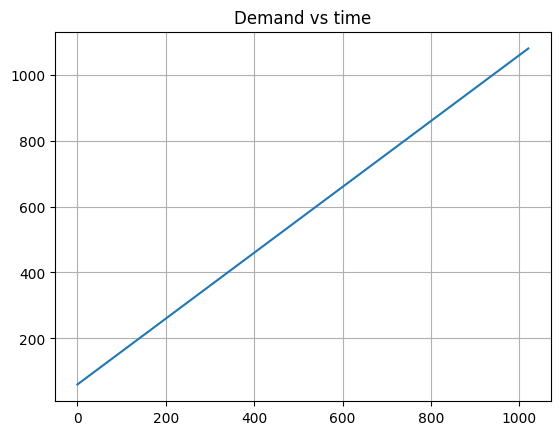

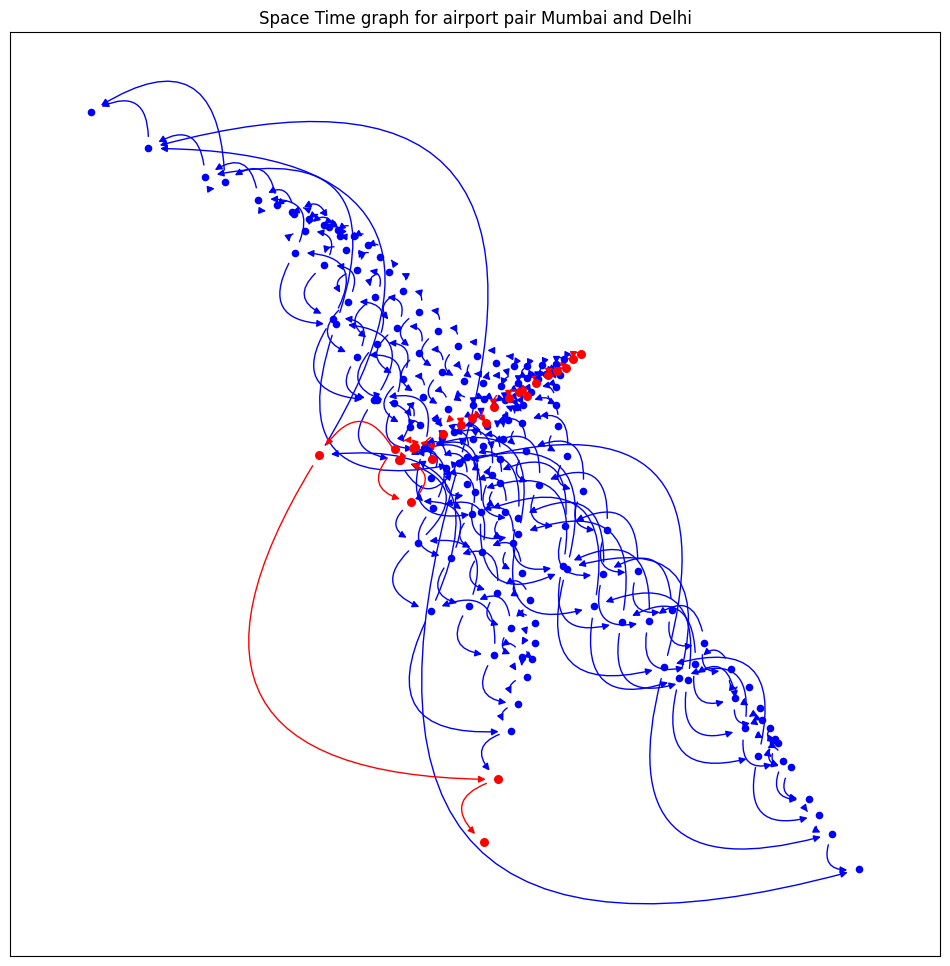

Flight Schedule for the day
╒═════════════════╤═════════════════════════════════════════╤═══════════════════════════════════════╕
│ Flight Number   │   Scheduled Departure (in 24hrs format) │   Scheduled Arrival (in 24hrs format) │
╞═════════════════╪═════════════════════════════════════════╪═══════════════════════════════════════╡
│ KF011           │                                       8 │                                 10.17 │
├─────────────────┼─────────────────────────────────────────┼───────────────────────────────────────┤
│ KF012           │                                      11 │                                 13.17 │
├─────────────────┼─────────────────────────────────────────┼───────────────────────────────────────┤
│ KF013           │                                      14 │                                 16.17 │
├─────────────────┼─────────────────────────────────────────┼───────────────────────────────────────┤
│ KF014           │                                   

In [177]:
init(0,1)

# Visualizing the results

In [138]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.7 MB/s eta 0:00:00



----------------------------------------------------------------------------------------------------------
AIRPORT WISE AIRLINE STATISTICS
----------------------------------------------------------------------------------------------------------
Choose an airport


Dropdown(options=('All', 'Mumbai', 'Delhi', 'Lucknow', 'Hyderabad', 'Ahmedabad', 'Banglore', 'Pune', 'Kolkata'…


----------------------------------------------------------------------------------------------------------
FLIGHT SCHEDULING FOR PAIR OF AIRPORTS
----------------------------------------------------------------------------------------------------------
Choose source airport


Dropdown(options=('Mumbai', 'Delhi', 'Lucknow', 'Hyderabad', 'Ahmedabad', 'Banglore', 'Pune', 'Kolkata', 'Chen…

Choose. destination airport


Dropdown(options=('Mumbai', 'Delhi', 'Lucknow', 'Hyderabad', 'Ahmedabad', 'Banglore', 'Pune', 'Kolkata', 'Chen…


----------------------------------------------------------------------------------------------------------
OUTPUT
----------------------------------------------------------------------------------------------------------

╒═══════════════╤════════════╤══════════════════════╤════════════════════════╤══════════╤═════════════╤═══════════════╕
│ Destination   │   Distance │   Block Time(in hrs) │   Cost per flight(INR) │   Demand │   # Flights │   Ticket cost │
╞═══════════════╪════════════╪══════════════════════╪════════════════════════╪══════════╪═════════════╪═══════════════╡
│ Mumbai        │    923.846 │              2.0265  │               154467   │     1499 │           9 │      1854.84  │
├───────────────┼────────────┼──────────────────────┼────────────────────────┼──────────┼─────────────┼───────────────┤
│ Delhi         │    228.918 │              1.25435 │                38275.1 │     1349 │           8 │       453.967 │
├───────────────┼────────────┼──────────────────────┼────

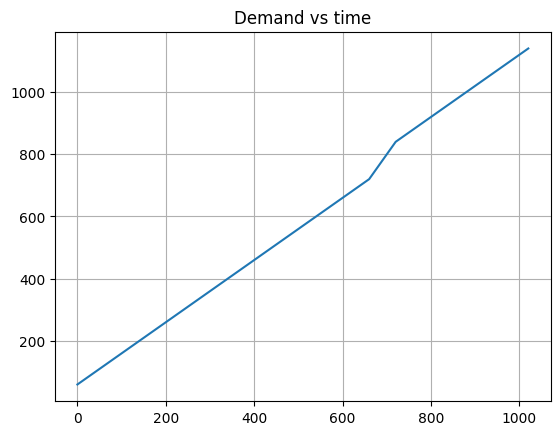

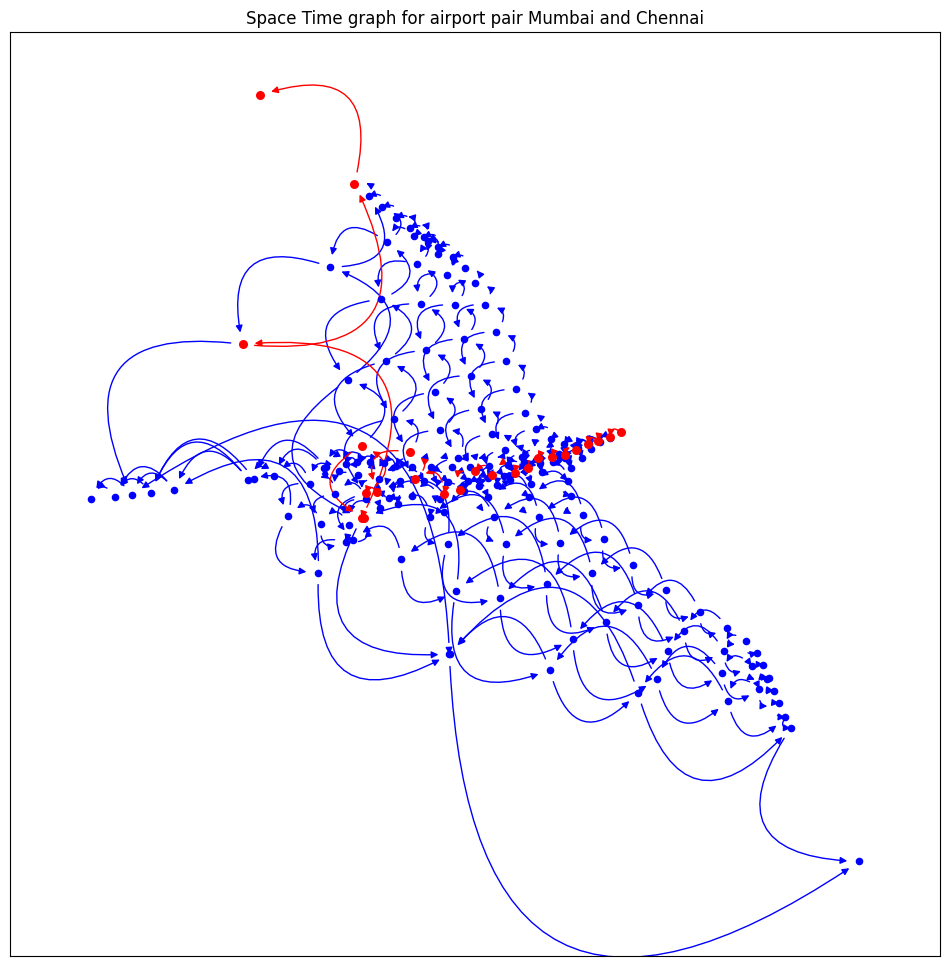

Flight Schedule for the day
╒═════════════════╤═════════════════════════════════════════╤═══════════════════════════════════════╕
│ Flight Number   │   Scheduled Departure (in 24hrs format) │   Scheduled Arrival (in 24hrs format) │
╞═════════════════╪═════════════════════════════════════════╪═══════════════════════════════════════╡
│ KF081           │                                       9 │                                 11.09 │
├─────────────────┼─────────────────────────────────────────┼───────────────────────────────────────┤
│ KF082           │                                      12 │                                 14.09 │
├─────────────────┼─────────────────────────────────────────┼───────────────────────────────────────┤
│ KF083           │                                      15 │                                 17.09 │
├─────────────────┼─────────────────────────────────────────┼───────────────────────────────────────┤
│ KF084           │                                   

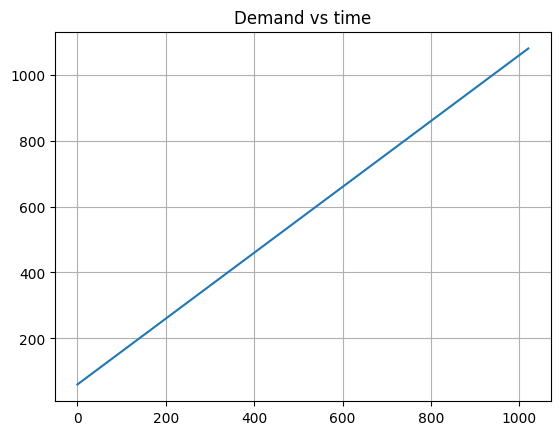

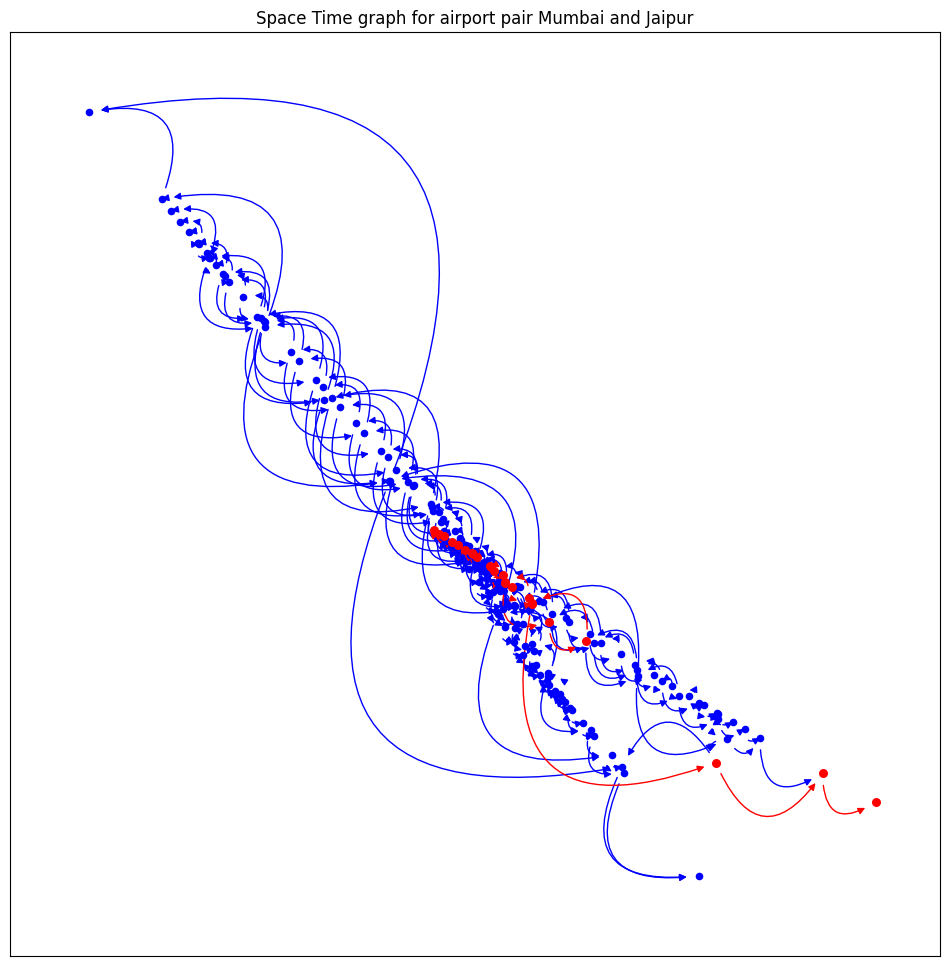

Flight Schedule for the day
╒═════════════════╤═════════════════════════════════════════╤═══════════════════════════════════════╕
│ Flight Number   │   Scheduled Departure (in 24hrs format) │   Scheduled Arrival (in 24hrs format) │
╞═════════════════╪═════════════════════════════════════════╪═══════════════════════════════════════╡
│ KF091           │                                       8 │                                 10.02 │
├─────────────────┼─────────────────────────────────────────┼───────────────────────────────────────┤
│ KF092           │                                      11 │                                 13.02 │
├─────────────────┼─────────────────────────────────────────┼───────────────────────────────────────┤
│ KF093           │                                      14 │                                 16.02 │
├─────────────────┼─────────────────────────────────────────┼───────────────────────────────────────┤
│ KF094           │                                   

In [205]:
import ipywidgets as widgets
dropdown_src = widgets.Dropdown(options = stations)
dropdown_dst = widgets.Dropdown(options = stations)
airports = ["All"]
for i in range(len(stations)):
  airports.append(stations[i])
dropdown_station = widgets.Dropdown(options = airports)
src=0
dst=0
def src_station_handler(change):
  for i in range(len(stations)):
    if stations[i] == change.new:
      src = i
  init(src, dst)
def dst_station_handler(change):
  for i in range(len(stations)):
    if stations[i] == change.new:
      dst = i
  init(src, dst)
def station_handler(change):
  if change.new == "All":
    get_all_stat()
  else:
    for i in range(len(stations)):
      if stations[i] == change.new:
        src = i
    get_airport_stat(i)
dropdown_src.observe(src_station_handler, names='value')
dropdown_dst.observe(dst_station_handler, names='value')
dropdown_station.observe(station_handler, names="value")
print("\n----------------------------------------------------------------------------------------------------------")
print("AIRPORT WISE AIRLINE STATISTICS")
print("----------------------------------------------------------------------------------------------------------")
print("Choose an airport")
display(dropdown_station)
print("\n----------------------------------------------------------------------------------------------------------")
print("FLIGHT SCHEDULING FOR PAIR OF AIRPORTS")
print("----------------------------------------------------------------------------------------------------------")
print("Choose source airport")
display(dropdown_src)
print("Choose. destination airport")
display(dropdown_dst)
print("\n----------------------------------------------------------------------------------------------------------")
print("OUTPUT")
print("----------------------------------------------------------------------------------------------------------\n")